In [1]:
import numpy as np

import matplotlib.pyplot as plt

import sys 
sys.path.append("..") 
from data import get_database_path, get_h5_files, read_h5_file
from visualize import plot_event_cloud, plot_hists


In [2]:
database_path = get_database_path()
print("Database Path:", database_path)


bkg_files, sig_files = get_h5_files()
print("bkg_files:", bkg_files)
print("sig_files:", sig_files)

Database Path: /home/desmondhe/Windows_D/ADwithAE
bkg_files: [{'type': 'SM', 'file': 'background_for_training.h5'}]
sig_files: [{'type': 'A->4_leptons', 'file': 'Ato4l_lepFilter_13TeV_filtered.h5'}, {'type': 'LQ_->b_tau', 'file': 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5'}, {'type': 'h^0->tau_tau', 'file': 'hToTauTau_13TeV_PU20_filtered.h5'}, {'type': 'h+->tau_nu', 'file': 'hChToTauNu_13TeV_PU20_filtered.h5'}]


In [3]:
print("Background Files:")
for dataset in bkg_files:
    print(dataset['type'], dataset['file'])

print("Signal Files:")
for dataset in sig_files:
    print(dataset['type'], dataset['file'])

Background Files:
SM background_for_training.h5
Signal Files:
A->4_leptons Ato4l_lepFilter_13TeV_filtered.h5
LQ_->b_tau leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
h^0->tau_tau hToTauTau_13TeV_PU20_filtered.h5
h+->tau_nu hChToTauNu_13TeV_PU20_filtered.h5


In [4]:
# bkg = read_h5_file(database_path, bkg_files[0]['file'])
# SM processes

datasets = np.load('../data/datasets_-1.npz')
background_ID = np.load('../data/background_IDs_-1.npz')
unpreprocessed_labels = ['x_train','x_test', 'x_val']
full_SM_dataset = np.concatenate([datasets[label] for label in unpreprocessed_labels], axis=0)
bkg = full_SM_dataset.reshape(full_SM_dataset.shape[:3])

ID_names = ['W', 'QCD', 'Z', 'ttbar']
set_labels = ['background_ID_train', 'background_ID_test', 'background_ID_val']
bkg_labels = np.concatenate([background_ID[label] for label in set_labels], axis=0)



neutral_boson = read_h5_file(database_path, sig_files[0]['file'])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, sig_files[1]['file'])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_higgs = read_h5_file(database_path, sig_files[2]['file'])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_higgs = read_h5_file(database_path, sig_files[3]['file'])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino



print(bkg.shape)
print(neutral_boson.shape)
print(leptoquark.shape)
print(neutral_higgs.shape)
print(charged_higgs.shape)

(14451914, 19, 3)
(55969, 19, 4)
(340544, 19, 4)
(691283, 19, 4)
(760272, 19, 4)


In [5]:
from emd import process_event_np
from data import mark_events

In [41]:
print(bkg[0])

[[13.65091991  0.         -1.61326444]
 [28.93702888  0.81659317 -1.67997897]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [45.79579163  0.89488125 -1.72020626]
 [44.72616959  2.7366116   1.03738618]
 [36.32344055 -0.62255085  2.19731951]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


Event 5797272 QCD
[[43.69227982  0.         -1.95644844  1.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [25.03956985  0.25665841  1.77550828  3.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


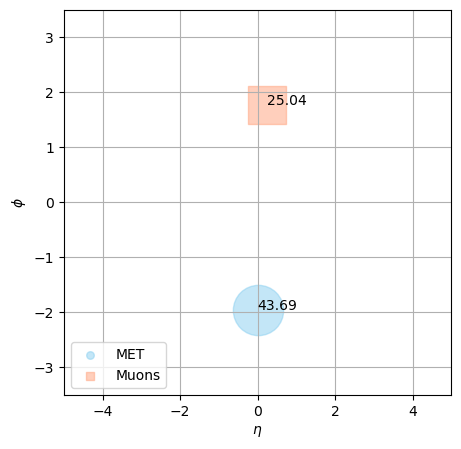

In [67]:
n = np.random.randint(bkg.shape[0])
n = 5797272
print("Event", n, ID_names[int(bkg_labels[n])])
test_event = mark_events(bkg[n])
print(test_event)
plot_event_cloud(test_event)
# print(process_event_np(test_event, particle_type_scale=1))

Event 47897
[[ 2.12935200e+01  0.00000000e+00 -2.69043159e+00  1.00000000e+00]
 [ 7.34823990e+01  4.05448712e-02  8.47969890e-01  2.00000000e+00]
 [ 8.90751934e+00  1.01499808e+00  8.65766466e-01  2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.52622852e+01 -9.88142118e-02  1.35626686e+00  3.00000000e+00]
 [ 1.06835165e+01 -1.98302329e-01  1.84176013e-01  3.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.81613846e+01  1.98264313e+00 -1.94129074e+00  4.00000000e+00]
 [ 7.48263855e+01  4.70554829e-02  8.50590527e-01  4.00000000e+00]
 [ 4.12432747e+01 -1.54735103e-01 -3.03520393e+00  4.00000000e+00]
 [ 2.52622852e+01 -9.88142118e-02  1.35626686e+00  4.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 

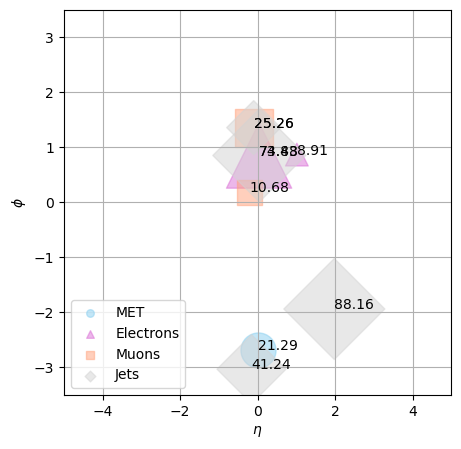

In [6]:
n = np.random.randint(neutral_boson.shape[0])
print("Event", n)
test_event = neutral_boson[n]
print(test_event)
plot_event_cloud(test_event)

In [42]:
bkg  = np.array(bkg)
pT_MET = bkg[:,0,0]
eta_MET = bkg[:,0,1]
phi_MET = bkg[:,0,2]

print("Max of p_T_MET:", max(pT_MET))
print("Max of eta_MET:", max(eta_MET))
print("Max of phi_MET:", max(phi_MET))

print("Min of p_T_MET:", min(pT_MET))
print("Min of eta_MET:", min(eta_MET))
print("Min of phi_MET:", min(phi_MET))



p_T_electrons = bkg[:,1:5,0]
eta_electrons = bkg[:,1:5,1]
phi_electrons = bkg[:,1:5,2]

print("Max of p_T_electrons:", max(p_T_electrons.flatten()))
print("Max of eta_electrons:", max(eta_electrons.flatten()))
print("Max of phi_electrons:", max(phi_electrons.flatten()))

print("Min of p_T_electrons:", min(p_T_electrons.flatten()))
print("Min of eta_electrons:", min(eta_electrons.flatten()))
print("Min of phi_electrons:", min(phi_electrons.flatten()))



p_T_muons = bkg[:,5:7,0]
eta_muons = bkg[:,5:7,1]
phi_muons = bkg[:,5:7,2]

print("Max of p_T_muons:", max(p_T_muons.flatten()))
print("Max of eta_muons:", max(eta_muons.flatten()))
print("Max of phi_muons:", max(phi_muons.flatten()))

print("Min of p_T_muons:", min(p_T_muons.flatten()))
print("Min of eta_muons:", min(eta_muons.flatten()))
print("Min of phi_muons:", min(phi_muons.flatten()))



p_T_jets = bkg[:,7:,0]
eta_jets = bkg[:,7:,1]
phi_jets = bkg[:,7:,2]

print("Max of p_T_jets:", max(p_T_jets.flatten()))
print("Max of eta_jets:", max(eta_jets.flatten()))
print("Max of phi_jets:", max(phi_jets.flatten()))

print("Min of p_T_jets:", min(p_T_jets.flatten()))
print("Min of eta_jets:", min(eta_jets.flatten()))
print("Min of phi_jets:", min(phi_jets.flatten()))

Max of p_T_MET: 7039.09521484375
Max of eta_MET: 0.0
Max of phi_MET: 3.141591787338257
Min of p_T_MET: 0.010911921970546246
Min of eta_MET: 0.0
Min of phi_MET: -3.141592502593994
Max of p_T_electrons: 1167.7591552734375
Max of eta_electrons: 2.9999992847442627
Max of phi_electrons: 3.141592502593994
Min of p_T_electrons: 0.0
Min of eta_electrons: -2.9999988079071045
Min of phi_electrons: -3.1415913105010986
Max of p_T_muons: 1229.38525390625
Max of eta_muons: 2.0999999046325684
Max of phi_muons: 3.141592502593994
Min of p_T_muons: 0.0
Min of eta_muons: -2.0999996662139893
Min of phi_muons: -3.141589403152466
Max of p_T_jets: 2026.547119140625
Max of eta_jets: 3.9999947547912598
Max of phi_jets: 3.141592025756836
Min of p_T_jets: 0.0
Min of eta_jets: -3.9999990463256836
Min of phi_jets: -3.141591787338257


In [34]:
def count_jets(events):
    jets = events[:, 9:19, :]
    jet_counts = np.sum(jets[:, :, 0] > 0, axis=1)
    
    return jet_counts

def count_electrons(events):
    electrons = events[:, 1:5, :]
    electron_counts = np.sum(electrons[:, :, 0] > 0, axis=1)
    
    return electron_counts

def count_muons(events):
    muons = events[:, 5:7, :]
    muon_counts = np.sum(muons[:, :, 0] > 0, axis=1)
    
    return muon_counts

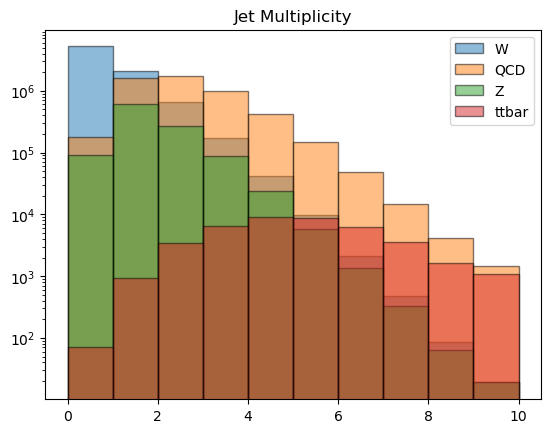

In [35]:
# plt.hist(count_jets(bkg), bins=range(11), alpha=0.5, label='Full SM')
plt.hist(count_jets(bkg[np.where(bkg_labels==0)]), bins=range(11), edgecolor='k', alpha=0.5, label='W')
plt.hist(count_jets(bkg[np.where(bkg_labels==1)]), bins=range(11), edgecolor='k', alpha=0.5, label='QCD')
plt.hist(count_jets(bkg[np.where(bkg_labels==2)]), bins=range(11), edgecolor='k', alpha=0.5, label='Z')
plt.hist(count_jets(bkg[np.where(bkg_labels==3)]), bins=range(11), edgecolor='k', alpha=0.5, label='ttbar')
plt.title('Jet Multiplicity')
plt.yscale('log')
plt.legend()
plt.show()


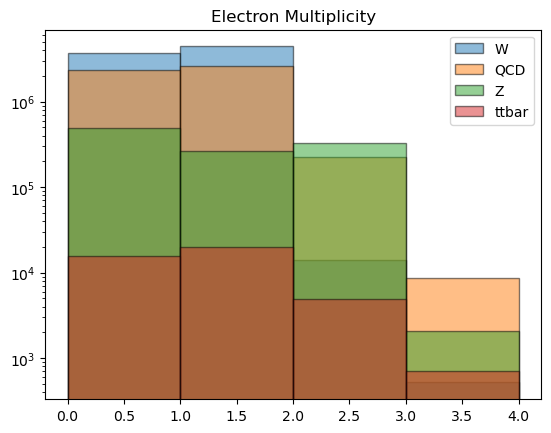

In [36]:
plt.hist(count_electrons(bkg[np.where(bkg_labels==0)]), bins=range(5), edgecolor='k', alpha=0.5, label='W')
plt.hist(count_electrons(bkg[np.where(bkg_labels==1)]), bins=range(5), edgecolor='k', alpha=0.5, label='QCD')
plt.hist(count_electrons(bkg[np.where(bkg_labels==2)]), bins=range(5), edgecolor='k', alpha=0.5, label='Z')
plt.hist(count_electrons(bkg[np.where(bkg_labels==3)]), bins=range(5), edgecolor='k', alpha=0.5, label='ttbar')
plt.title('Electron Multiplicity')
plt.yscale('log')
plt.legend()
plt.show()

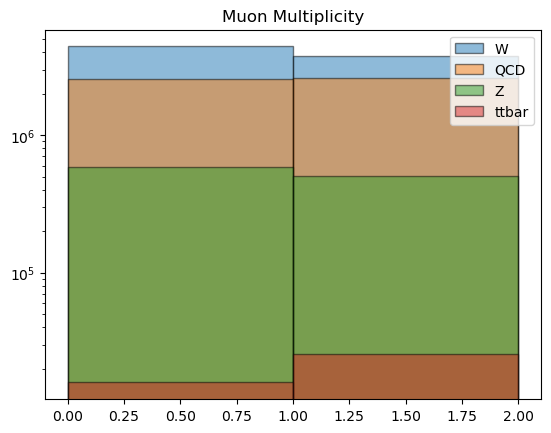

In [37]:
plt.hist(count_muons(bkg[np.where(bkg_labels==0)]), bins=range(3), edgecolor='k', alpha=0.5, label='W')
plt.hist(count_muons(bkg[np.where(bkg_labels==1)]), bins=range(3), edgecolor='k', alpha=0.5, label='QCD')
plt.hist(count_muons(bkg[np.where(bkg_labels==2)]), bins=range(3), edgecolor='k', alpha=0.5, label='Z')
plt.hist(count_muons(bkg[np.where(bkg_labels==3)]), bins=range(3), edgecolor='k', alpha=0.5, label='ttbar')
plt.title('Muon Multiplicity')
plt.yscale('log')
plt.legend()
plt.show()

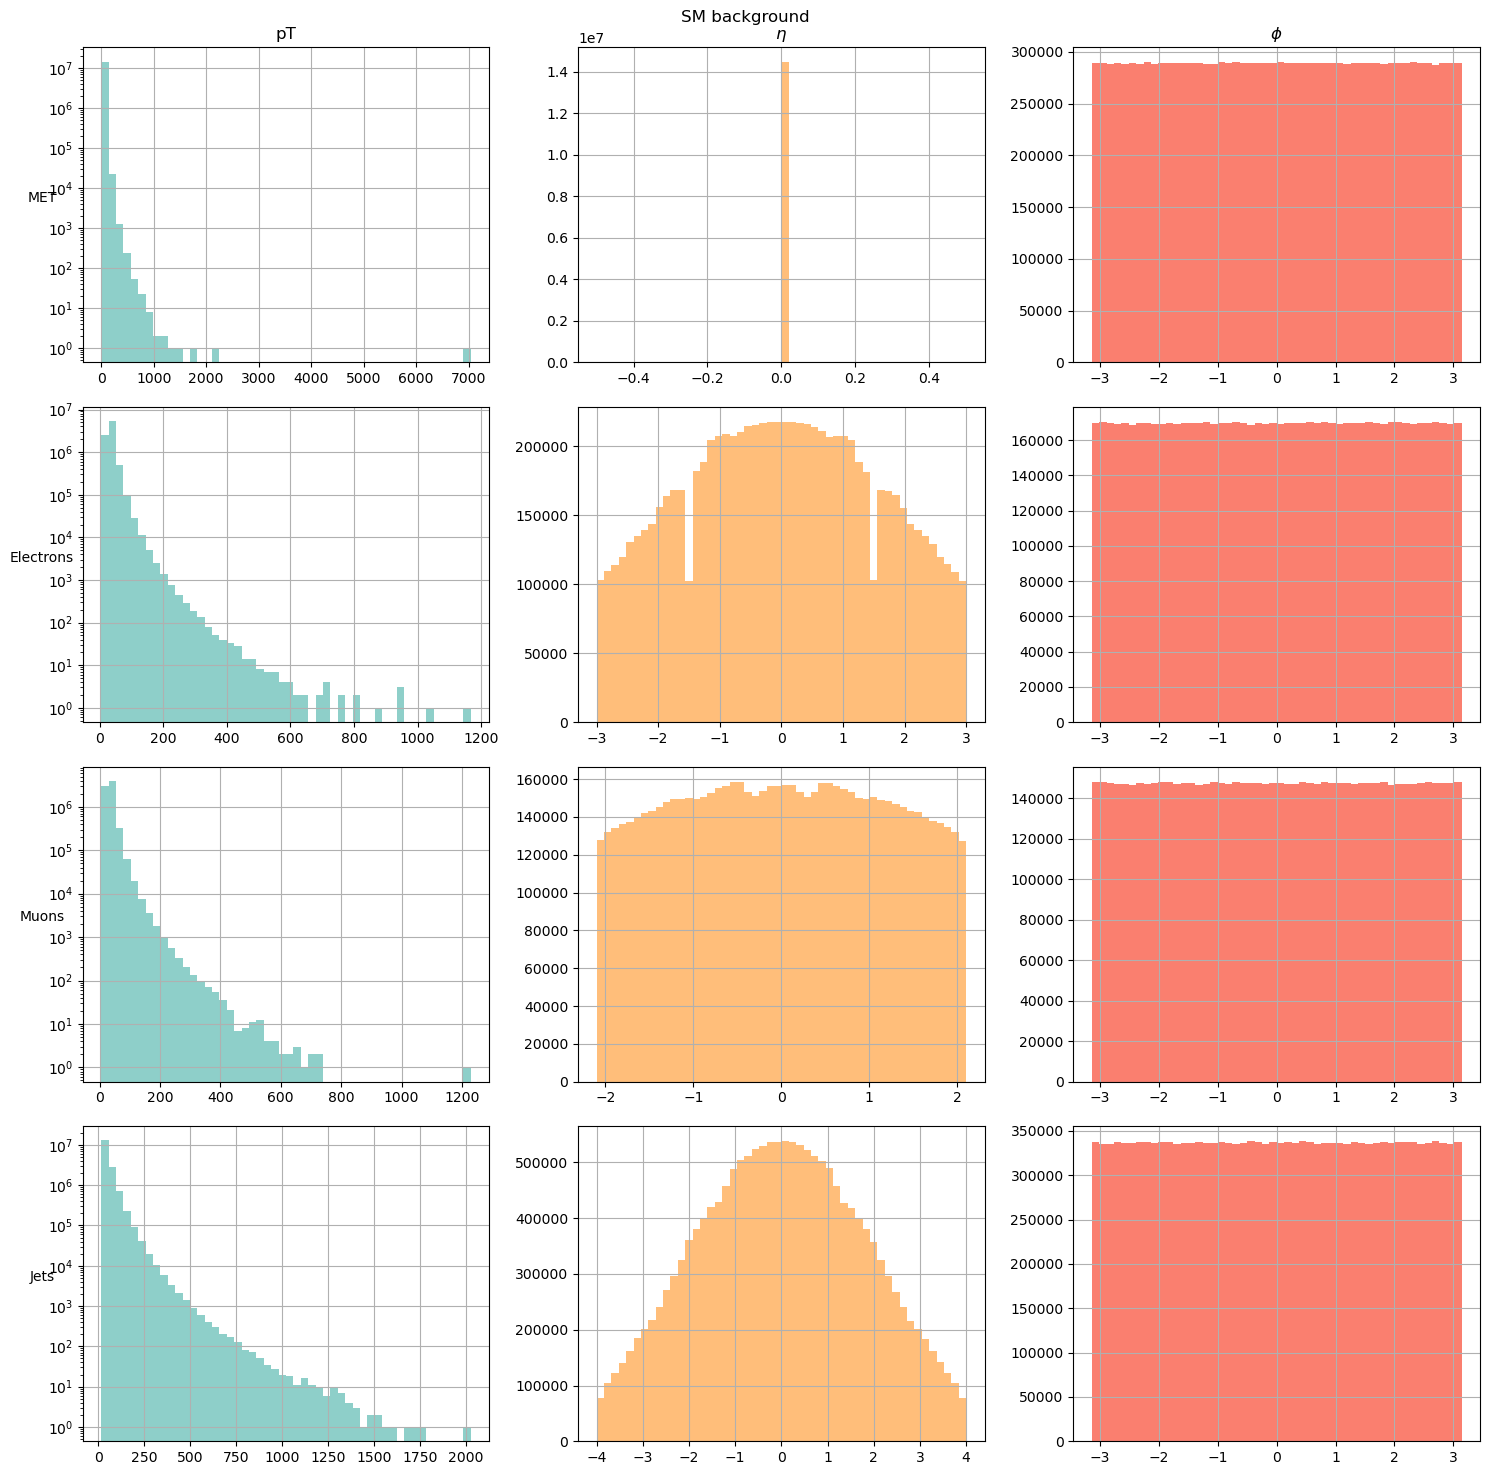

In [17]:
plot_hists(mark_events(bkg), "SM background")

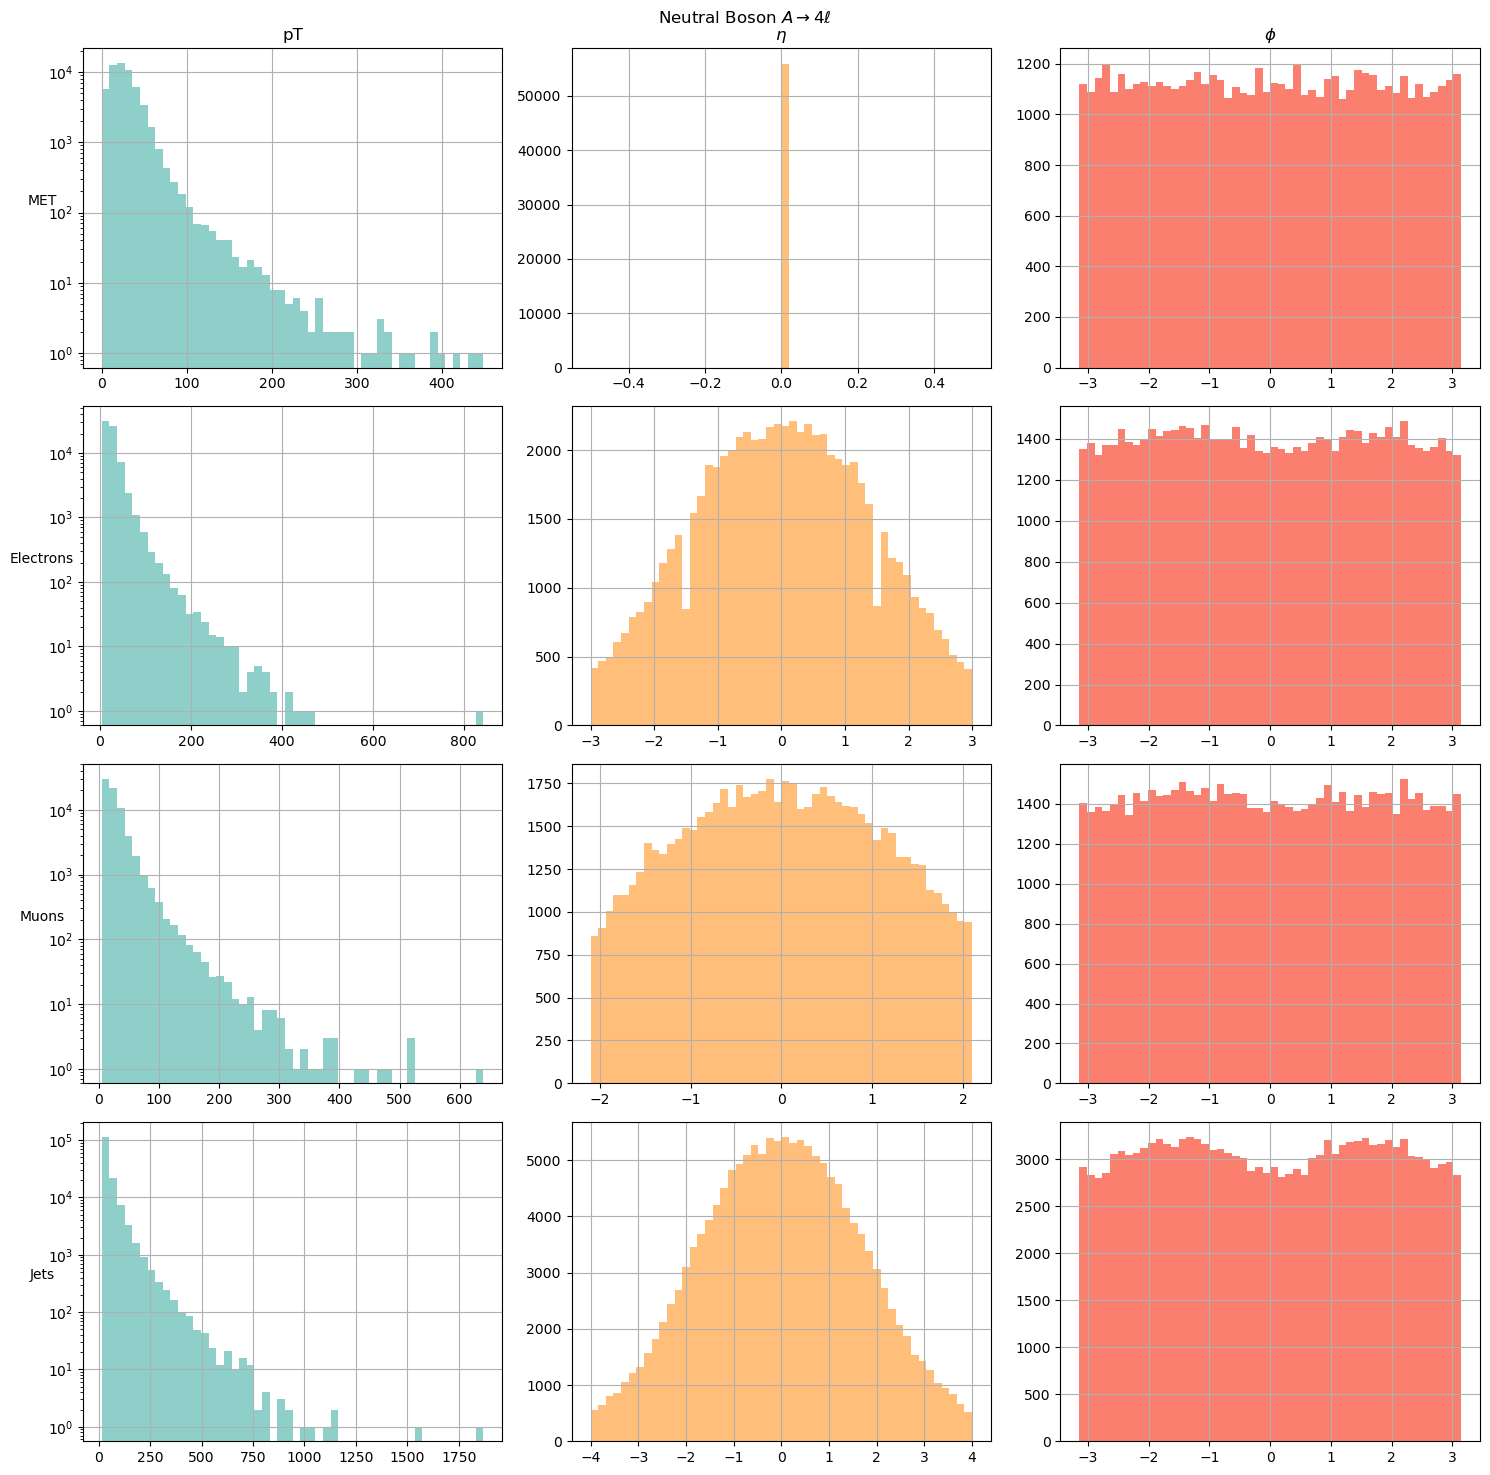

In [10]:
plot_hists(neutral_boson, r"Neutral Boson $A \rightarrow 4 \ell$")

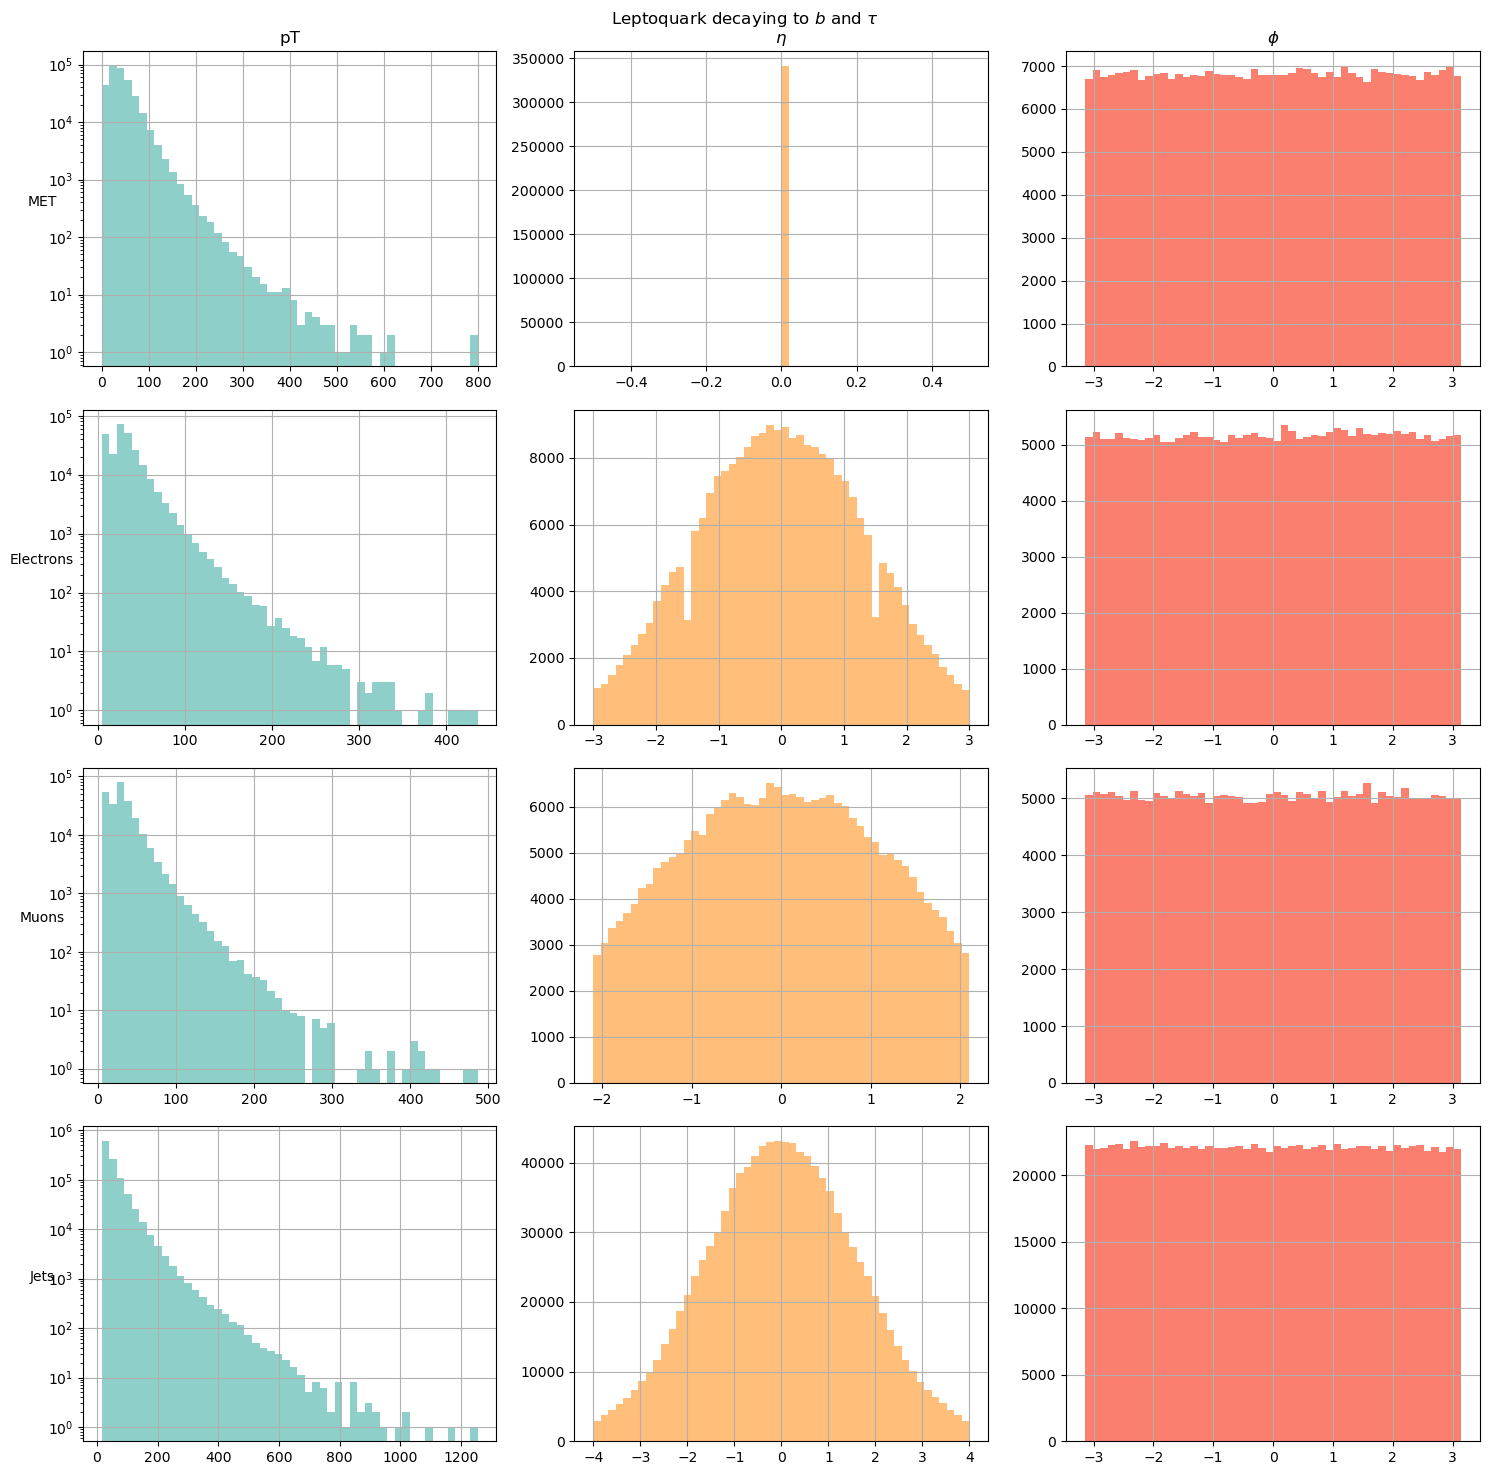

In [11]:
plot_hists(leptoquark, r"Leptoquark decaying to $b$ and $\tau$")

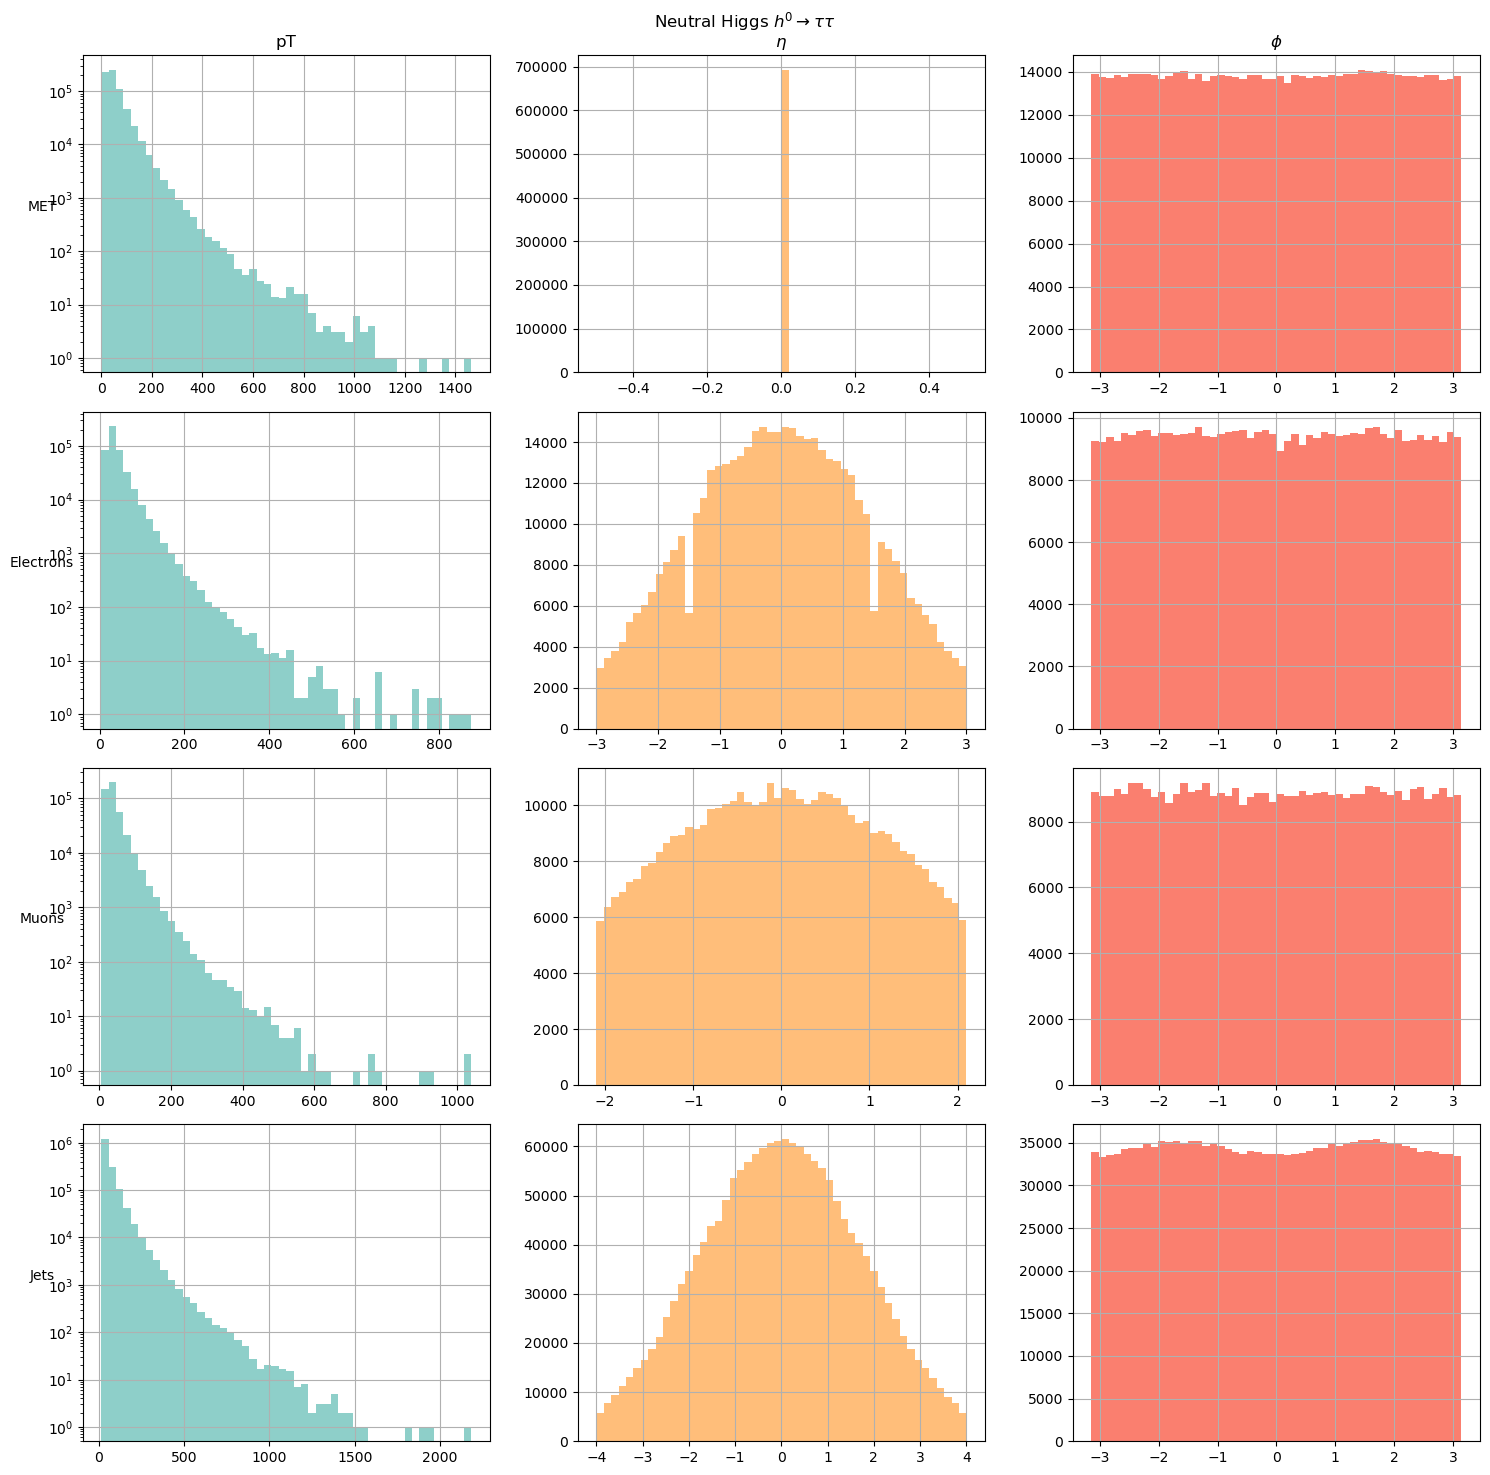

In [12]:
plot_hists(neutral_higgs, r"Neutral Higgs $h^0 \rightarrow \tau \tau$")

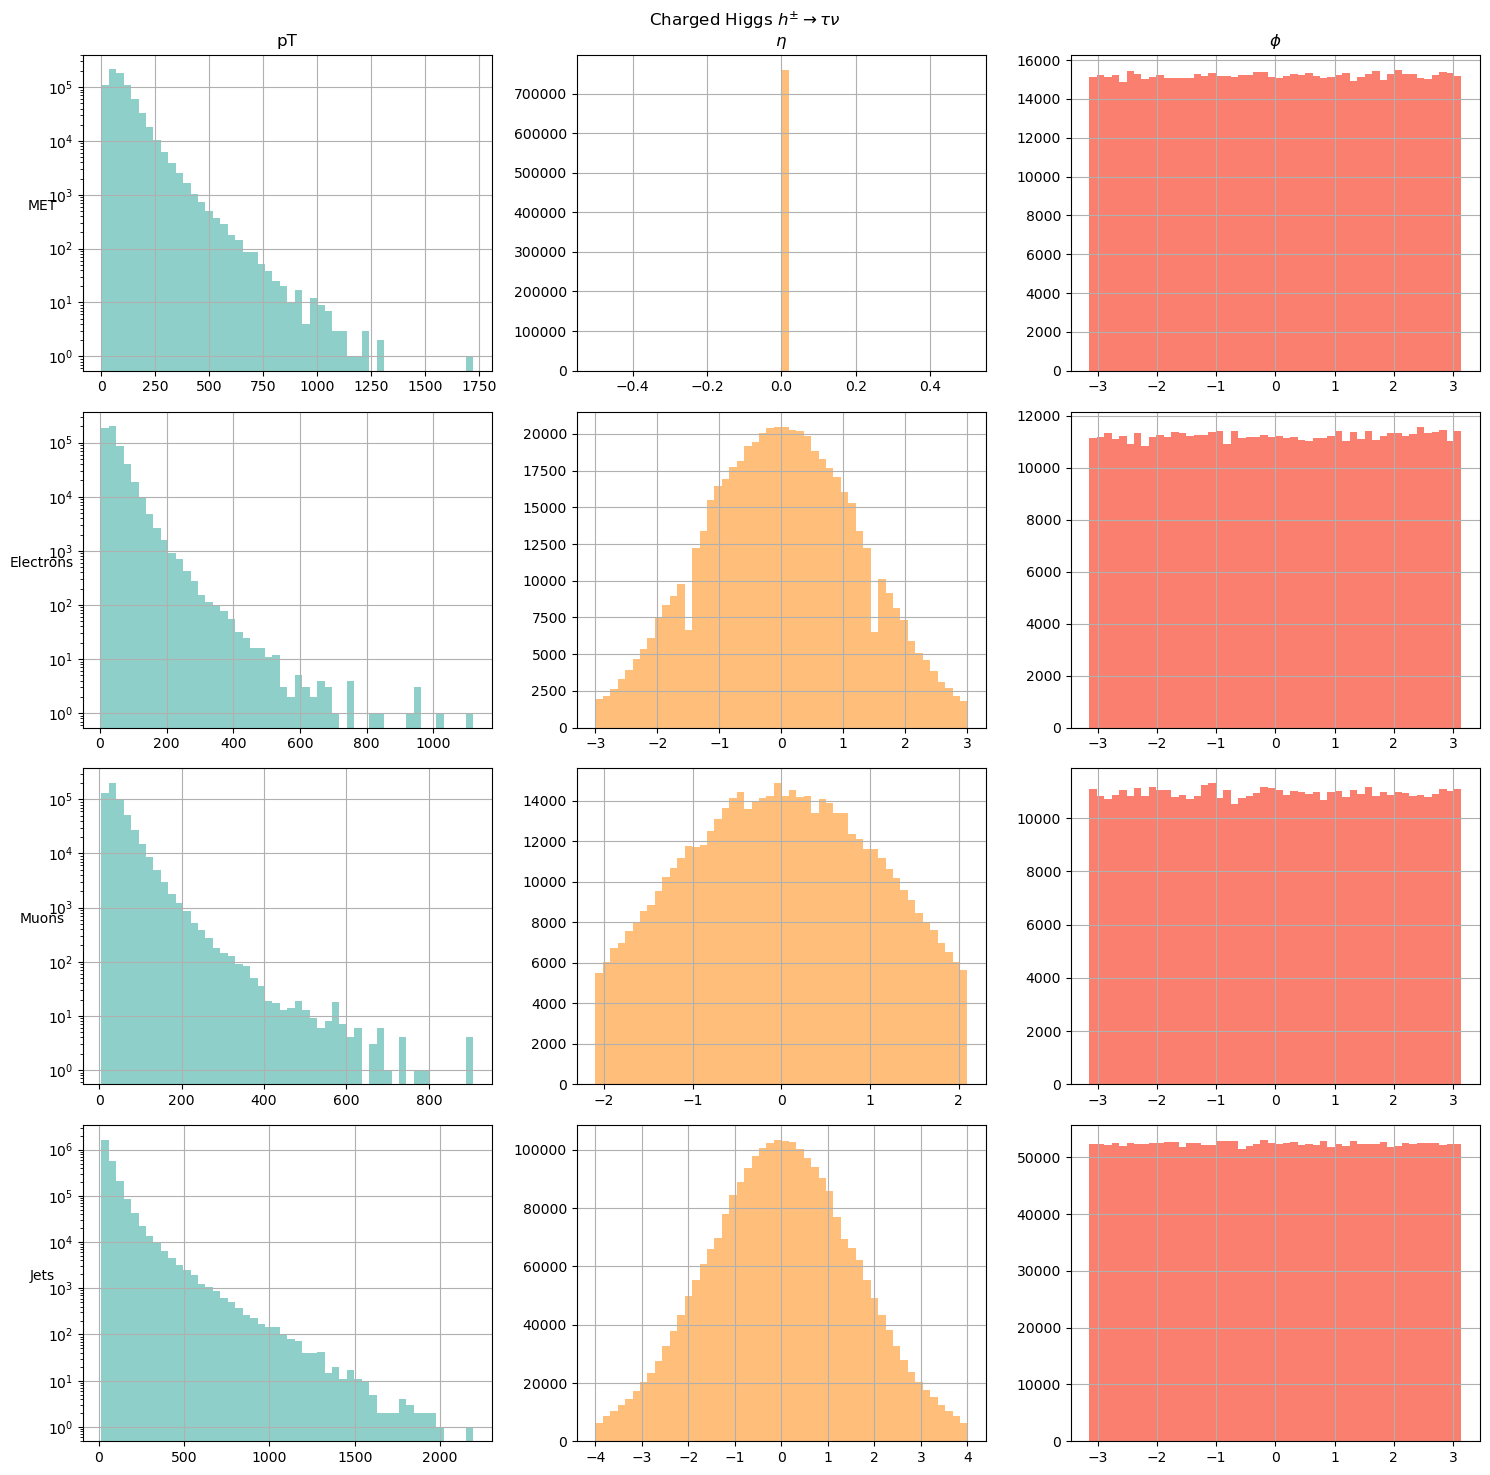

In [13]:
plot_hists(charged_higgs, r"Charged Higgs $h^{ \pm} \rightarrow \tau \nu$")